In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import custom libraries
import utils

In this notebook we build a model to forecast `Premium Wineries Gross Margins (%)`.

### Metrics
| Model | MAE | RSE | R-squared |
|:-------|-----|-----|-----------|
|Linear Regression (baseline)|2.882|14.320|-14.037|
|Holt-Winters|4.317|24.240|-22.656|
|ARIMA|**2.430**|**9.212**|**-7.782**|
|ARIMAX|2.055|5.698|-4.115|
|DLM|3.525|20.574|-20.498|

## Load Data

In [2]:
data = pd.read_csv("forecast_data.csv")
data.shape

(24, 22)

In [4]:
columns = ["Year", "US Wine Production (Mgal)", "Median Income", "Num Seniors", "Num w/ small children", "US Wine Sales Volume (Mgal)", "Premium Wineries Gross Margins (%)"]

In [5]:
data = data[columns].copy()
data["Year"] = pd.to_datetime(data["Year"], format='%Y')
data = data.set_index("Year")
data.index.freq = 'AS-JAN' 
data = data.sort_index()
data.shape

(24, 6)

Fill missing values in other variables besides `US Wine Production (Mgal)`

In [7]:
data = utils.linear_interpolation(data, columns=["US Wine Production (Mgal)"])

Target value is missing the last year

In [8]:
data = data[3:]

## Visualization and Correlations

<AxesSubplot:xlabel='Year', ylabel='Premium Wineries Gross Margins (%)'>

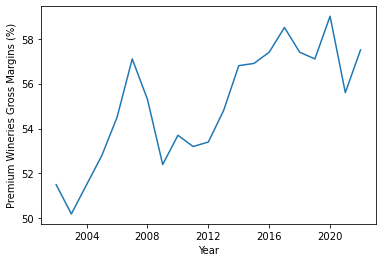

In [9]:
sns.lineplot(data=data, x=data.index, y="Premium Wineries Gross Margins (%)")

In [10]:
utils.adf_test(data["Premium Wineries Gross Margins (%)"])

(0.0369721462654605, 0.961484929220273)

The data is not stationary

In [32]:
stationary_data = data.copy()

In [33]:
stationary_data["Premium Wineries Gross Margins (%)"] = utils.make_stationary(df=stationary_data, column_name="Premium Wineries Gross Margins (%)", lag=4)
stationary_data = stationary_data.iloc[4:]
stationary_data.shape

(17, 6)

In [34]:
utils.adf_test(stationary_data["Premium Wineries Gross Margins (%)"])

(-3.007253016681956, 0.03422258908448574)

<AxesSubplot:xlabel='Year', ylabel='Premium Wineries Gross Margins (%)'>

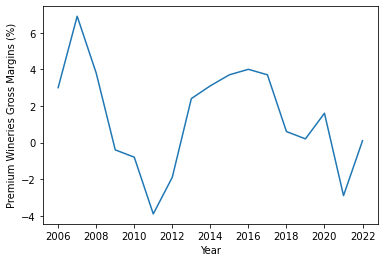

In [35]:
sns.lineplot(data=stationary_data, x=stationary_data.index, y="Premium Wineries Gross Margins (%)")

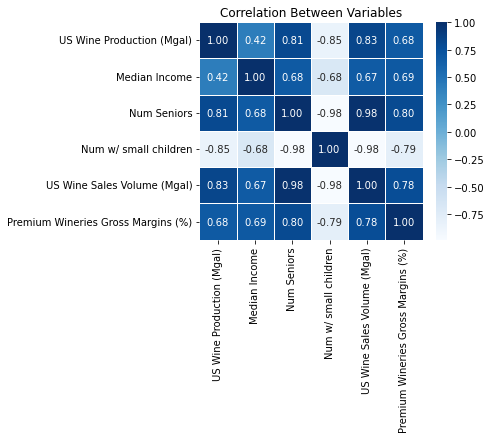

In [38]:
utils.visualize_correlation(utils.calculate_correlation(data), figsize=(5,4))

## Baseline

In [39]:
from sklearn.linear_model import Ridge, LinearRegression

In [40]:
baseline_data = data["Premium Wineries Gross Margins (%)"].copy()

In [41]:
baseline_data = baseline_data.reset_index()
baseline_data["Year"] = baseline_data["Year"].dt.year

In [43]:
baseline_train, baseline_test = utils.split_dataset(baseline_data, test_size=0.2)
baseline_train.shape, baseline_test.shape

((16, 2), (5, 2))

In [44]:
ridge_reg = Ridge()
ridge_reg.fit(baseline_train.values[:,:-1], baseline_train.values[:,-1])

# Calculate metrics
baseline_preds = ridge_reg.predict(baseline_test.values[:,:-1])
baseline_mae, baseline_mse, baseline_r2 = utils.calculate_metrics(baseline_preds, baseline_test.values[:,-1])
print(f"MAE: {baseline_mae:.5f}, MSE: {baseline_mse:.5f}, R-squared: {baseline_r2:.5f}")

MAE: 1.42315, MSE: 3.26828, R-squared: -1.78484


<AxesSubplot:xlabel='Year', ylabel='Premium Wineries Gross Margins (%)'>

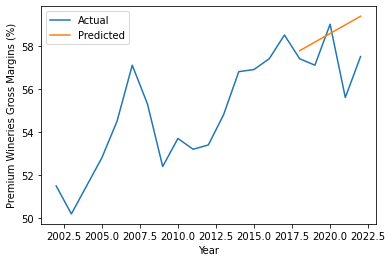

In [45]:
sns.lineplot(data=baseline_data, x="Year", y="Premium Wineries Gross Margins (%)", label="Actual")
sns.lineplot(x=baseline_test["Year"], y=baseline_preds, label="Predicted")

Cross-Validation

In [46]:
utils.stats_models_cv(model_name="lr", data=baseline_data, n_folds=3)

Mean MAE: 2.8826233124621115
Mean MSE: 14.320068757405894
Mean R-squared: -14.037622179744034
Train sizes: min=6, max=16
Test sizes: min=5, max=5

Metrics in non-stationary context


## Statistical Models

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pydlm import dlm, dynamic, trend

In [48]:
target = ["Premium Wineries Gross Margins (%)"]

### Holt-Winters Exponential Smoothing

In [49]:
hw_data = data[target].copy()

In [51]:
hw_train, hw_test = utils.split_dataset(hw_data, test_size=0.2)
hw_train.shape, hw_test.shape

((16, 1), (5, 1))

In [52]:
# Fit model
hw_model = ExponentialSmoothing(hw_train, trend='add', seasonal='add', seasonal_periods=8)
hw_model = hw_model.fit()

# Calculate metrics
forecast_hw = hw_model.forecast(steps=len(hw_test))
hw_mae, hw_mse, hw_r2 = utils.calculate_metrics(forecast_hw, hw_test)
print(f"MAE: {hw_mae:.5f}, MSE: {hw_mse:.5f}, R-squared: {hw_r2:.5f}")

MAE: 1.89250, MSE: 3.90241, R-squared: -2.32516


<AxesSubplot:xlabel='Year', ylabel='Premium Wineries Gross Margins (%)'>

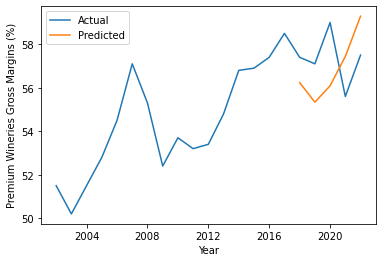

In [53]:
sns.lineplot(data=hw_data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=forecast_hw.index, y=forecast_hw.values, label="Predicted")

Cross-Validation

In [54]:
hw_params = {"seasonal_periods": "half"}
utils.stats_models_cv(model_name="holt-winters", data=hw_data, params=hw_params, n_folds=3)

Mean MAE: 4.317482016515913
Mean MSE: 24.24089734908431
Mean R-squared: -22.656035554052988
Train sizes: min=6, max=16
Test sizes: min=5, max=5

Metrics in non-stationary context


In [57]:
hw_params = {"seasonal_periods": "half"}
utils.stats_models_cv(model_name="holt-winters", data=hw_data, stationary_column=target[0], params=hw_params, n_folds=3)

'column' made stationary with lag=4
Mean MAE: 3.2024562441828848
Mean MSE: 17.611766346475235
Mean R-squared: -2.3378191976334133
Train sizes: min=5, max=13
Test sizes: min=4, max=4

Metrics in non-stationary context
Mean MAE: 4.35659162818914
Mean MSE: 26.927069670908836
Mean R-squared: -40.31212876038614


C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))


### ARIMA

In [58]:
arima_data = data[target].copy()

In [60]:
arima_train, arima_test = utils.split_dataset(arima_data, test_size=0.2)
arima_train.shape, hw_test.shape

((16, 1), (5, 1))

In [61]:
# Train model
p, d, q = 4, 1, 1
arima_model = ARIMA(arima_train, order=(p, d, q))
arima_model = arima_model.fit()

# Calculate metrics
forecast_arima = arima_model.forecast(steps=len(arima_test))
arima_mae, arima_mse, arima_r2 = utils.calculate_metrics(forecast_arima, arima_test)
print(f"MAE: {arima_mae:.5f}, MSE: {arima_mse:.5f}, R-squared: {arima_r2:.5f}")

MAE: 1.04970, MSE: 1.89545, R-squared: -0.61507


<AxesSubplot:xlabel='Year', ylabel='Premium Wineries Gross Margins (%)'>

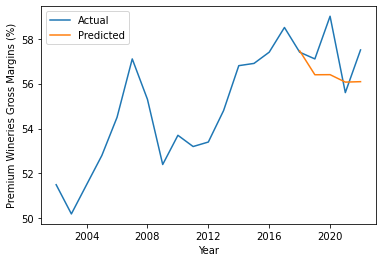

In [62]:
sns.lineplot(data=data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=forecast_arima.index, y=forecast_arima.values, label="Predicted")

Cross-Validation

In [64]:
arima_params = {"p": 4, "d": 1, "q": 1}
utils.stats_models_cv(model_name="arima", data=hw_data, params=arima_params, n_folds=3)

Mean MAE: 2.430573870154458
Mean MSE: 9.211953745853204
Mean R-squared: -7.782052478777504
Train sizes: min=6, max=16
Test sizes: min=5, max=5

Metrics in non-stationary context


C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [68]:
arima_params = {"p": 1, "d": 1, "q": 1}
utils.stats_models_cv(model_name="arima", data=hw_data, stationary_column=target[0], params=arima_params, n_folds=3)

'column' made stationary with lag=4
Mean MAE: 1.8228186636634558
Mean MSE: 4.633555397788299
Mean R-squared: -0.04482525382053463
Train sizes: min=5, max=13
Test sizes: min=4, max=4

Metrics in non-stationary context
Mean MAE: 2.506428983369366
Mean MSE: 9.834079468626484
Mean R-squared: -7.788032207242761


C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))


### Dynamic Linear Models (DLM)

#### Without additional features
We assume a linearity of the data and we only use the target variable.

In [76]:
dlm_data = data[target].copy()

In [77]:
dlm_train, dlm_test = utils.split_dataset(dlm_data, test_size=0.2)
dlm_train.shape, dlm_test.shape

((16, 1), (5, 1))

In [78]:
# Fit model on train data
dlm_model = dlm(dlm_train.values)
# Given the data is linear, we add a linear trend component
dlm_model = dlm_model + trend(degree=1, discount=0.9)
dlm_model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


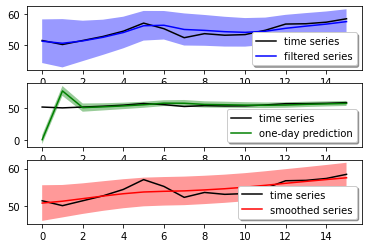

<Figure size 432x288 with 0 Axes>

In [79]:
dlm_model.plot()
plt.tight_layout()

In [80]:
# Forecast the next steps
forecast_dlm = dlm_model.predictN(N=len(dlm_test))[0]

In [81]:
dlm_mae, dlm_mse, dlm_r2 = utils.calculate_metrics(forecast_dlm, dlm_test)
print(f"MAE: {dlm_mae:.5f}, MSE: {dlm_mse:.5f}, R-squared: {dlm_r2:.5f}")

MAE: 1.61872, MSE: 4.27191, R-squared: -2.64001


<AxesSubplot:xlabel='Year', ylabel='Premium Wineries Gross Margins (%)'>

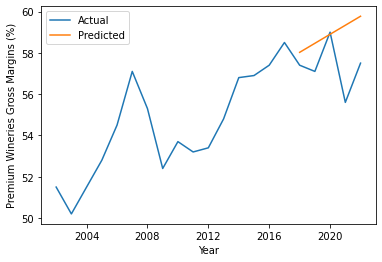

In [82]:
sns.lineplot(data=data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=dlm_test.index, y=forecast_dlm, label="Predicted")

Cross-validation

In [83]:
dlm_params = {"discount": 0.90, "features_data": "linear"}
utils.stats_models_cv(model_name="dlm", data=dlm_data, params=dlm_params, n_folds=3)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Mean MAE: 3.52525483036974
Mean MSE: 20.57406914489515
Mean R-squared: -20.498197391567885
Train sizes: min=6, max=16
Test sizes: min=5, max=5

Metrics in non-stationary context


In [84]:
dlm_params = {"discount": 0.90, "features_data": "poly"}
utils.stats_models_cv(model_name="dlm", data=dlm_data, stationary_column=target[0], params=dlm_params, n_folds=3)

'column' made stationary with lag=4
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Mean MAE: 3.855613192340357
Mean MSE: 21.829050235829786
Mean R-squared: -4.229655752272929
Train sizes: min=5, max=13
Test sizes: min=4, max=4

Metrics in non-stationary context
Mean MAE: 3.1859710249858337
Mean MSE: 18.40049888453263
Mean R-squared: -18.194977904253744


C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\ml_test_project\french_winery\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
